In [5]:
import numpy as np
import pandas as pd
from sklearn import neighbors
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import naive_bayes
%matplotlib inline
from sklearn import metrics
from sklearn.naive_bayes import GaussianNB


from sklearn.model_selection import cross_val_score
from imblearn.over_sampling import RandomOverSampler

In [2]:
from scipy.stats import pearsonr
from sklearn import linear_model
from sklearn.svm import l1_min_c
from scipy import stats

from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split

In [4]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import mutual_info_classif

In [6]:
y = pd.read_csv('task1_7_learn_y.csv', sep=' ', header=None)
target = np.int64(y.values[:,0])
print(target.shape)

(1000,)


In [7]:
X = pd.read_csv('task1_7_learn_X.csv', sep=' ', header=None )
test = pd.read_csv('task1_7_test_X.csv', sep=' ', header=None )
X.shape, test.shape

((1000, 50), (1000, 50))

In [9]:
data = pd.DataFrame(np.hstack([X,y.values.reshape(-1,1)]))

### Заменим все выбросы

In [8]:
def replace_outliers(X, alpha):
    num_features = X.shape[1]
    q_low = X.quantile(alpha, axis=0)
    q_up = X.quantile(1 - alpha, axis=0)
    X_new = X.values.copy()
    print(num_features, X.shape[0])
    for i in range(num_features):
        median = X[i].median()
        for j in range(X.shape[0]):
            if X_new[j][i] < q_low[i] or X_new[j][i] > q_up[i]:
                X_new[j][i] = median
    return X_new
        

In [9]:
X_without_out = replace_outliers(X, 0.0141)

50 1000


In [10]:
test_clear = replace_outliers(test, 0.0111)
print(np.max(test_clear))

50 1000
3.1537966622843654


## Отбор признаков

In [11]:
#skb = SelectKBest(f_classif, k=1)
#skb = SelectKBest(f_classif, k=1)
skb = SelectKBest(mutual_info_classif, k=1)
#skb = SelectKBest(chi2, k=1)
skb.fit(X_without_out, target)

SelectKBest(k=1, score_func=<function mutual_info_classif at 0x7fb3b3bfe2f0>)

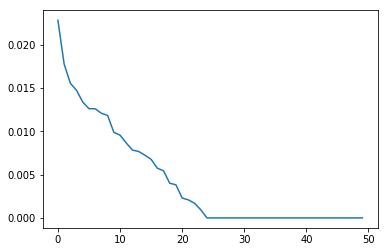

In [12]:
a = np.sort(skb.scores_)[::-1]
# a = a[a < 0.005]//
# print(np.max(np.where(a>0)))
plt.plot(a)

In [13]:
NUM_K = 21
print(a)

[0.0228376  0.01778073 0.01556562 0.01473498 0.01338179 0.01262004
 0.01260718 0.01209486 0.01184031 0.00989486 0.00956309 0.00865749
 0.00783907 0.00767545 0.0072472  0.00677289 0.00574489 0.00544717
 0.00400995 0.00382597 0.00230035 0.00208325 0.00169321 0.00093957
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]


In [14]:
X_meow = scale(np.vstack([X_without_out, test_clear]))[:,np.where(skb.scores_ >= skb.scores_[np.argsort(skb.scores_)[::-1][NUM_K-1]])[0]]
# X = np.vstack([X_train_load, X_test_load])[:,np.where(skb.scores_ >= skb.scores_[np.argsort(skb.scores_)[::-1][NUM_K-1]])[0]]
# X = (X - np.mean(X, axis=0))/np.std(X, axis=0)

X_train = X_meow[:X.shape[0]]
X_test = X_meow[X.shape[0]:]

y_train = target

In [17]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)

(1000, 21)
(1000,)
(1000, 21)


### Ошибки

In [15]:
def asy1(estimator, X, y):
    Penalty_1 = np.array([[-10,10], [1,0]])
    answ = np.int64(estimator.predict(X))
    return np.sum(Penalty_1[y, answ])
    
def asy2(estimator, X, y):
    Penalty_2 = np.array([[-1,2], [1,-1]])
    answ = np.int64(estimator.predict(X))
    return np.sum(Penalty_2[y, answ])

def _asy1(y1, y2):
    Penalty_1 = np.array([[-10,10], [1,0]])
    return np.sum(Penalty_1[y1, y2])

def _asy2(y1, y2):
    Penalty_2 = np.array([[-1,2], [1,-1]])
    return np.sum(Penalty_2[y1, y2])
def num(estimator, X, y):
    answ = np.int64(estimator.predict(X))
    num = np.sum(np.abs(answ - y) > 0)
    return num

### Оверсамплинг

In [16]:
from sklearn import svm
from imblearn.over_sampling import SMOTE, ADASYN

X_resampled, y_resampled = SMOTE().fit_sample(X_train, y_train)

### Наивный байес 

In [17]:
ACC = cross_val_score(estimator=naive_bayes.GaussianNB(), X=X_resampled, y=y_resampled, scoring='roc_auc', cv = 10)
AUC = cross_val_score(estimator=naive_bayes.GaussianNB(), X=X_resampled, y=y_resampled, scoring='accuracy', cv = 10)

ASY1 = cross_val_score(estimator=naive_bayes.GaussianNB(), X=X_resampled, y=y_resampled, scoring=asy1, cv = 10)
ASY2 = cross_val_score(estimator=naive_bayes.GaussianNB(), X=X_resampled, y=y_resampled, scoring=asy2, cv = 10)
NUM = cross_val_score(estimator=naive_bayes.GaussianNB(), X=X_resampled, y=y_resampled, scoring=num, cv = 10)

print('ACC:', np.mean(ACC), np.std(ACC))
print('AUC:', np.mean(AUC), np.std(AUC))
print('NUM:', np.mean(NUM), np.std(NUM))
print('ASY1:', np.mean(ASY1), np.std(ASY1))
print('ASY2:', np.mean(ASY2), np.std(ASY2))

ACC: 0.7800511246142589 0.07948480609541095
AUC: 0.7083857729138168 0.06080880773315804
NUM: 50.1 10.463746938836012
ASY1: -309.2 58.909761500111344
ASY2: -45.3 19.98024023879593


## Генерим ответы

In [20]:
model = naive_bayes.GaussianNB()
model.fit(X_resampled, y_resampled)
y_max_auc = model.predict(X_test)

In [29]:
y_max_ASY2 = np.zeros(1000)
y = model.predict(X_train)

In [32]:
def Criteria(y, y_pred):
    fpr, tpr, thresholds = metrics.roc_curve(y, y_pred)
    auc = metrics.auc(fpr, tpr)
    num = np.sum(np.abs((y - y_pred)))
    Penalty1 = np.array([[-10,10], [1,0]])
    Penalty2 = np.array([[-1,2], [1,-1]])
    
    print('AUC', auc)
    print('NUM',num)
    asy1 = 0
    asy2 = 0
    for i in range(y_pred.shape[0]):
        asy1 += Penalty1[y[i], y_pred[i]]
        asy2 += Penalty2[y[i], y_pred[i]]
    print('ASY1:', asy1)
    print('ASY2:', asy2)

    print('ACC:', np.sum(y_pred == y)/np.size(y))

In [33]:
Criteria(y, y_train)

AUC 0.5396168753726893
NUM 331
ASY1: -5029
ASY2: -258
ACC: 0.669
